## Introduction

#### 用户有两个关于自然语言的特征               
1. introductoin
2. 粉丝的 commen cloud

如果只用introduction预测用户的标签，34分类下，大概有33%的准确率               
如果加入commend cloud,能够提高15%左右的准确率  

**试图用和商品同样的方法获取用户的tag**                
拼死可能也到不了50%，很大的原因是数据量太小                 



In [1]:
import pymysql
import pandas as pd
import numpy as np
import re
import jieba

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

TENCENT_VECTOR_PATH = '/Users/huan/Desktop/weibo/word_vector/Tencent_AILab_ChineseEmbedding.txt'
MAX_VOCAB_SIZE = 50000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 200

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
conn = pymysql.connect(host = '127.0.0.1', 
                       user = 'root', 
                       password = 'root123', 
                       db = 'delidou')

In [3]:
df = pd.read_sql_query('select id,introduction as name,tag from base_user_info', conn)
df2 = pd.read_sql_query('select id, comment_cloud from base_user_fans', conn)

In [6]:
import json
clouds = []
for comment in df2.comment_cloud:
    c = json.loads(comment)
    if not len(c)>=5:
        clouds.append('')
        continue
    all_words = ' '
    for dic in c:
        all_words+=dic['name'] +' '
    clouds.append(all_words)
    
df2.loc[:,'comment_cloud'] = clouds

In [7]:
def find_chinese(file):
    pattern = re.compile(r'[^\u4e00-\u9fa5]')
    chinese = re.sub(pattern, '', file)
    return chinese

def replace_puncs(x):
    return re.sub(r'[^\w\s]','',x)

def remove_blanks(x):
    return re.sub(r'\s{2,}','',x)

def cut_text(x):
    return list(jieba.cut(x,cut_all=False))

def preprocess_texts(df):

    df['clean_name'] = df.name.apply(remove_blanks).apply(replace_puncs).apply(find_chinese).values
    df['cutted_text'] = df.clean_name.apply(cut_text).values
    df['texts'] = df.cutted_text.apply(lambda x:' '.join(x)).values
    df.loc[:,'sequence_length'] = df.cutted_text.apply(lambda x:len(x)).values
    df = df[(df.sequence_length >0) & (df.sequence_length <= MAX_SEQUENCE_LENGTH)]
    return df

In [8]:
df = df[~df.name.isnull()]
df = preprocess_texts(df)

Building prefix dict from the default dictionary ...
I0713 01:23:20.145413 4573179328 __init__.py:111] Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/jh/q3qgwx4n59b_rg88dkbcb20m0000gn/T/jieba.cache
I0713 01:23:20.147619 4573179328 __init__.py:131] Loading model from cache /var/folders/jh/q3qgwx4n59b_rg88dkbcb20m0000gn/T/jieba.cache
Loading model cost 0.643 seconds.
I0713 01:23:20.790501 4573179328 __init__.py:163] Loading model cost 0.643 seconds.
Prefix dict has been built succesfully.
I0713 01:23:20.792256 4573179328 __init__.py:164] Prefix dict has been built succesfully.


In [9]:
df = df.merge(df2, on = 'id', how = 'left')
df['texts'] = df['texts'] + df['comment_cloud']

In [10]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df.texts)
num_words = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
print('Number of word considered: {}'.format(num_words))
word2index = tokenizer.word_index

Number of word considered: 48751


In [11]:
sequences = tokenizer.texts_to_sequences(df.texts)

In [12]:
padded_sequences = pad_sequences(sequences,maxlen = MAX_SEQUENCE_LENGTH)

In [13]:
embeddings_index = dict()
with open(TENCENT_VECTOR_PATH,'r', encoding = 'utf-8') as f:
    next(f)
    for line in f:
        values = line.split(' ')
        word = values[0]
        if word in word2index:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    f.close()
    
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, ind in word2index.items():
    if ind < MAX_VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[ind] = embedding_vector

In [14]:
from keras.layers import Input,Dense, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding,concatenate,Flatten,Dropout
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [15]:
nonnull_index = np.where((df.tag != '').values)[0]
features = padded_sequences[nonnull_index]
targets = pd.Categorical(df.iloc[nonnull_index,:]['tag'])
idx_to_cat = {idx:cat for idx, cat in enumerate(pd.Categorical(targets.categories))}
targets = targets.codes
K = max(idx_to_cat) + 1

In [29]:
embedding_layer = Embedding(num_words,
                    EMBEDDING_DIM,
                    weights = [embedding_matrix],
                    input_length = MAX_SEQUENCE_LENGTH,
                    trainable = False)

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = Embedding(input_dim=num_words, output_dim=200, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix],trainable=False)(inputs)
l_conv01 = Conv1D(128, 2,activation='relu',padding='same')(embedded_sequences)
l_pool01 = MaxPooling1D(2)(l_conv01)
l_conv02 = Conv1D(128, 3,activation='relu',padding='same')(embedded_sequences)
l_pool02 = MaxPooling1D(3)(l_conv02)
l_conv03 = Conv1D(128, 4,activation='relu',padding='same')(embedded_sequences)
l_pool03 = MaxPooling1D(4)(l_conv03)
l_merge = concatenate([l_pool01,l_pool02, l_pool03],axis=1)

l_cov2 = Conv1D(128, 3, activation='relu',padding='same')(l_merge)
l_pool2 = MaxPooling1D(10)(l_cov2)
l_pool2 = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_pool2)
l_dense = Dropout(0.5)(l_dense)
l_dense = Dense(64, activation='relu')(l_dense)
encoder = Model(inputs, l_dense)

encoded_vector = encoder(inputs)

preds = Dense(K, activation='softmax')(encoded_vector)

model=Model(inputs,preds)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [30]:
from keras.utils import plot_model

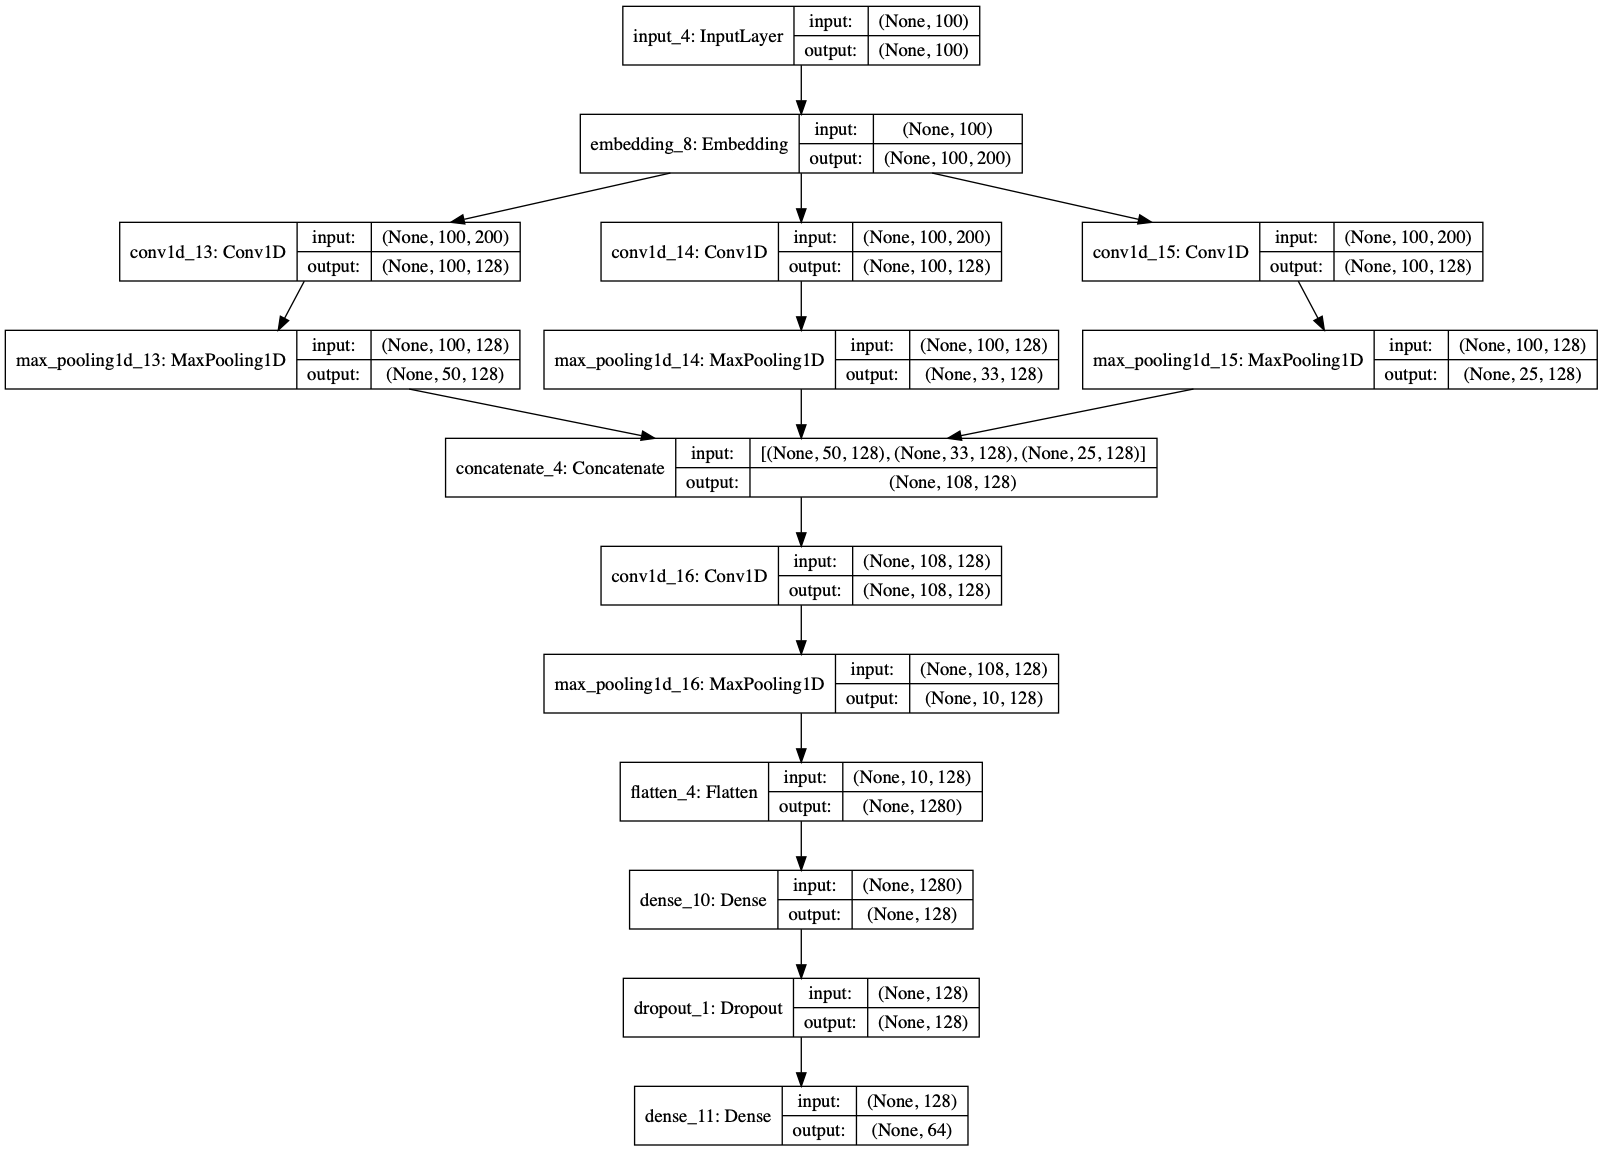

In [31]:
plot_model(encoder,show_shapes=True)

In [34]:
model.fit(features, targets,batch_size =128,epochs = 10,validation_split = 0.3)

Train on 5763 samples, validate on 2471 samples
Epoch 1/1
5763/5763 [==============================] - 7s 1ms/step - loss: 1.0987 - accuracy: 0.6649 - val_loss: 2.2701 - val_accuracy: 0.4779


In [35]:
pd.set_option('max_rows',1000)
pd.set_option('max_columns',100)

In [36]:
tmp = df.copy()

In [37]:
padded_sequences = pad_sequences(tokenizer.texts_to_sequences(preprocess_texts(tmp).texts), maxlen = MAX_SEQUENCE_LENGTH)
preds = model.predict(padded_sequences).argmax(axis = 1)

In [38]:
tmp['predictions'] = [idx_to_cat[p] for p in preds]

In [39]:
# import seaborn as sns
# from IPython.core.pylabtools import figsize
# figsize(20,20)
# sns.heatmap(pd.crosstab(tmp.tag, tmp.predictions), annot = True)

In [40]:
pd.crosstab(tmp.tag, tmp.predictions)

predictions,健康,其他,剧情,动漫,品味,奇趣,宠物,家居,少儿,影视,情感,搭配,政务,教学,教育,旅行,母婴,汽车,生活,知识,种草,科技,美妆,职场,舞蹈,蓝V,运动,音乐,食品
tag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
健康,262,0,1,11,13,3,1,1,0,0,0,4,2,3,4,2,18,2,0,8,6,2,8,36,0,0,1,0,1
其他,11,0,4,23,16,12,10,0,1,2,1,1,1,7,13,3,22,7,0,44,11,4,3,30,0,0,1,0,0
剧情,20,0,10,46,20,11,5,0,0,0,1,2,1,2,9,2,18,2,0,55,11,7,2,51,0,0,0,0,3
动漫,9,0,1,101,9,18,14,0,0,0,0,0,0,7,8,5,29,3,0,47,6,4,2,17,0,0,0,0,0
品味,17,0,1,13,90,12,2,0,0,0,0,5,0,3,5,1,16,5,0,22,20,6,10,17,0,0,0,0,0
奇趣,10,0,1,17,2,21,2,0,0,0,0,0,1,11,3,4,12,1,0,22,5,10,0,17,0,0,1,0,0
宠物,7,0,2,13,6,6,62,0,0,0,0,0,0,0,1,0,8,1,0,16,3,1,1,5,0,0,1,0,0
家居,4,0,0,1,3,2,1,64,0,0,0,0,0,6,1,2,1,15,0,9,5,3,1,13,0,0,0,0,1
少儿,12,0,3,5,9,3,6,0,0,1,0,1,0,0,5,1,54,1,0,11,3,1,1,4,0,0,0,0,0


In [42]:
tmp[tmp.tag!=tmp.predictions].head(300)

,id,name,tag,clean_name,cutted_text,texts,sequence_length,comment_cloud,predictions
1,100009521785,双胞胎宝妈一枚\n记录和婆婆在一起带娃美食日常\n谢谢亲们那么优秀还关注着我\n同频宝妈❤m...,食品,双胞胎宝妈一枚记录和婆婆在一起带娃美食日常谢谢亲们那么优秀还关注着我同频宝妈,"[双胞胎, 宝妈, 一枚, 记录, 和, 婆婆, 在, 一起, 带娃, 美食, 日常, 谢谢...",双胞胎 宝妈 一枚 记录 和 婆婆 在 一起 带娃 美食 日常 谢谢 亲们 那么 优秀 还 ...,21,婆婆 我们 明明 什么 好吃 自己 可以 喜欢 这个 没有 老公 这样 怎么 孩子 不是 ...,母婴
2,100011394784,噗，一只蹦哒在时尚最前端的兔子 \n工作：fatu1818 \n兔粉+fatu360\n...,生活,噗一只蹦哒在时尚最前端的兔子工作兔粉仅此一个时尚菌发兔兔粉们看准喽,"[噗, 一只, 蹦, 哒, 在, 时尚, 最, 前端, 的, 兔子, 工作, 兔粉, 仅, ...",噗 一只 蹦 哒 在 时尚 最 前端 的 兔子 工作 兔粉 仅 此 一个 时尚 菌 发兔 兔...,22,,食品
3,100012587574,聚焦，分享，传递正能量,政务,聚焦分享传递正能量,"[聚焦, 分享, 传递, 正, 能量]",聚焦 分享 传递 正 能量,5,判刑 一个 就是 这个 司机 什么 中国 这样 没有 应该 不是 怎么 点赞 知道 自己 ...,职场
4,100012830831,每晚上8点～10点直播。欢迎友友们🌹🌹🌹,舞蹈,每晚上点点直播欢迎友友们,"[每, 晚上, 点点, 直播, 欢迎, 友友, 们]",每 晚上 点点 直播 欢迎 友友 们,7,美女 漂亮 跳得 谢谢 真棒 晚上 快乐 美美 早上好 好看 棒棒 不错 跳舞 姐姐 这个...,健康
6,10001683194,谢谢你的关注\n🧣一只猎豹8013,帅哥,谢谢你的关注一只猎豹,"[谢谢, 你, 的, 关注, 一只, 猎豹]",谢谢 你 的 关注 一只 猎豹,6,老公 可以 喜欢 这个 卧槽 哥哥 啊啊啊 腹肌 一个 帅哥 什么 哈哈哈 第一 好看 姐...,宠物
7,100018564661,在路上8年，这次出国8个月\n更多分享关注v:40193379，铁粉私信\n去巴基斯坦印度非...,旅行,在路上年这次出国个月更多分享关注铁粉私信去巴基斯坦印度非洲唯一的旅行主播背包穷游去过个国家微...,"[在, 路上, 年, 这次, 出国, 个, 月, 更, 多, 分享, 关注, 铁粉, 私信,...",在 路上 年 这次 出国 个 月 更 多 分享 关注 铁粉 私信 去 巴基斯坦 印度 非洲 ...,29,中国 印度 美丽 他们 非洲 一个 回来 不是 巴基斯坦 自己 不要 美女 什么 注意安全...,教学
8,100019656635,一枚狮子座的剪辑手🤖\n用心做好每一个视频🎃\n感谢大家支持❤️,影视,一枚狮子座的剪辑手用心做好每一个视频感谢大家支持,"[一枚, 狮子座, 的, 剪辑, 手, 用心, 做好, 每, 一个, 视频, 感谢, 大家,...",一枚 狮子座 的 剪辑 手 用心 做好 每 一个 视频 感谢 大家 支持,13,什么 一个 这个 电视剧 就是 没有 电影 不是 这样 真的 自己 男人 现在 有钱 时候...,奇趣
9,100020090563,玩，，，，，抖音声音音，生活的幸福，永远在我的心中，人生苦短，不管是，是谁都一样,生活,玩抖音声音音生活的幸福永远在我的心中人生苦短不管是是谁都一样,"[玩抖音, 声音, 音, 生活, 的, 幸福, 永远, 在, 我, 的, 心中, 人生, 苦...",玩抖音 声音 音 生活 的 幸福 永远 在 我 的 心中 人生 苦短 不管 是 是 谁 都 一样,19,美女 早上好 你好 亲爱 喜欢 漂亮 谢谢 感谢 晚上 可以 接福 爱心 朋友 平平 性感...,动漫
10,100020547730,🧣weibo：泰勒斯资讯\n①所有视频禁止盗用！\n②欢迎投稿～\n③B站：TaylorSw...,明星,泰勒斯资讯所有视频禁止盗用欢迎投稿站资讯找图群,"[泰勒斯, 资讯, 所有, 视频, 禁止, 盗用, 欢迎, 投稿, 站, 资讯, 找, 图群]",泰勒斯 资讯 所有 视频 禁止 盗用 欢迎 投稿 站 资讯 找 图群,12,哈哈哈 霉霉 啊啊啊 哈哈哈哈 这个 喜欢 真的 好听 可以 什么 不是 哈哈 哪里 中国...,知识
11,100020658088,欢迎关注 🥰🥰\n🧣：一只小相-\n🍠：一只小相\n🔗衣服：很多只小相,影视,欢迎关注一只小相一只小相衣服很多只小相,"[欢迎, 关注, 一只, 小相, 一只, 小相, 衣服, 很多, 只小相]",欢迎 关注 一只 小相 一只 小相 衣服 很多 只小相,9,喜欢 这样 一个 这个 真的 哈哈哈 不是 什么 就是 知道 没有 我们 可以 好看 不会...,宠物
